<a href="https://colab.research.google.com/github/alexferrero23/twitter-category-nlp/blob/develop/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re
import io

#### Select your file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving working_df (1).orc to working_df (1).orc


In [3]:
import pyarrow.orc 

df = pd.read_orc('working_df (1).orc')

In [4]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-03-23 18:53:00,"Madeleine Albright often said, “There is a spe...",en,D,56.0,196.0,117
1,RepAdams,2022-03-22 14:40:16,Judge Ketanji Brown Jackson:✔️ Received a unan...,en,D,13.0,26.0,115
2,RepAdams,2022-03-21 20:59:02,When I Grow Up is a virtual forum designed to ...,en,D,5.0,4.0,117
3,RepAdams,2022-03-21 19:55:53,"Ketanji Brown Jackson's parents, Ellery &amp; ...",en,D,8.0,31.0,120
4,RepAdams,2022-03-21 13:58:54,Judge Ketanji Brown Jackson is the most qualif...,en,D,19.0,102.0,117


In [5]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
import string
list_of_rubish = ['&amp;', '-', '…', '’', '“', '—', '”', 'amp'] #stop_words.extend(("amp"))

def create_corpus_column(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    cleaned_corpus = []
    corpus = tokenizer.tokenize(tweet)
    for word in corpus:
        if (word not in stop) and (word not in list_of_rubish) and (word not in string.punctuation):
             cleaned_corpus.append(word)
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df['text_corpus'] = df['text'].apply(create_corpus_column)

In [7]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepAdams,2022-03-23 18:53:00,"Madeleine Albright often said, “There is a spe...",en,D,56.0,196.0,117,"[madeleine, albright, often, said, special, pl..."
1,RepAdams,2022-03-22 14:40:16,Judge Ketanji Brown Jackson:✔️ Received a unan...,en,D,13.0,26.0,115,"[judge, ketanji, brown, jackson, ✔, ️, receive..."
2,RepAdams,2022-03-21 20:59:02,When I Grow Up is a virtual forum designed to ...,en,D,5.0,4.0,117,"[grow, virtual, forum, designed, inspire, wome..."
3,RepAdams,2022-03-21 19:55:53,"Ketanji Brown Jackson's parents, Ellery &amp; ...",en,D,8.0,31.0,120,"[ketanji, brown, jackson's, parents, ellery, j..."
4,RepAdams,2022-03-21 13:58:54,Judge Ketanji Brown Jackson is the most qualif...,en,D,19.0,102.0,117,"[judge, ketanji, brown, jackson, qualified, su..."


In [8]:
for i in range(0,20):
  print(df['text_corpus'][i])
  print(df['text'][i])

['madeleine', 'albright', 'often', 'said', 'special', 'place', 'hell', 'women', 'help', 'feminis']
Madeleine Albright often said, “There is a special place in hell for women who don't help each other.” As a feminis… 
['judge', 'ketanji', 'brown', 'jackson', '✔', '️', 'received', 'unanimous', 'well', 'qualified', 'rating', 'nonpartisan', 'american', 'bar', 'ass']
Judge Ketanji Brown Jackson:✔️ Received a unanimous "Well Qualified" rating from the nonpartisan American Bar Ass… 
['grow', 'virtual', 'forum', 'designed', 'inspire', 'women', 'girls', 'open', 'panelists', 'share']
When I Grow Up is a virtual forum designed to inspire women and girls, but is open to all. Our panelists will share… 
['ketanji', 'brown', "jackson's", 'parents', 'ellery', 'johnny', 'brown', 'graduated', 'hbcus', 'giving', 'daughter', 'oppo']
Ketanji Brown Jackson's parents, Ellery &amp; Johnny Brown, both graduated from HBCUs - giving their daughter the oppo… 
['judge', 'ketanji', 'brown', 'jackson', 'qualified', 

In [9]:
# Unnest of text_corpus
df_tidy = df.explode(column='text_corpus')
df_tidy = df_tidy.drop(columns='text')
df_tidy.head(3)

,username,created_at,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepAdams,2022-03-23 18:53:00,en,D,56.0,196.0,117,madeleine
0,RepAdams,2022-03-23 18:53:00,en,D,56.0,196.0,117,albright
0,RepAdams,2022-03-23 18:53:00,en,D,56.0,196.0,117,often


In [10]:
# Data pivot by label
df_pivot = df_tidy.groupby(["label","text_corpus"])["text_corpus"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "text_corpus" , columns="label", values= "count")
df_pivot.columns.name = None

In [11]:
# Consine similarity
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivot.corr(method=similitud_coseno)

,D,R
D,1.000000,0.918538
R,0.918538,1.000000


#### ***This is actually really bad news, if there is a big correlation between both groups, its gonna be really difficult to say whether a tweet tends to be republican or democrat***

---



#MODEL
#### For the feature extraction, I'm gonna use Tf-idf (Term frequency – Inverse document frequency) (Weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise)

In [27]:
#For model purposes, lets change label from letters to numbers: R -> 0 and D -> 1

df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

In [29]:
#train-test split
from sklearn.model_selection import train_test_split

datos_X = df.text
datos_y = df.label_number

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [30]:
#check of proportions
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 44.48858946022954, 1: 55.51141053977046}
{0: 44.59244268101084, 1: 55.40755731898916}


In [31]:
#Tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    corpus = tokenizer.tokenize(tweet)
    return corpus

vectorizer  = TfidfVectorizer(
                        tokenizer  = tokenize,
                        min_df     = 5 #might change
                    )
vectorizer.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=5, tokenizer=<function tokenize at 0x7fede173b200>)

In [32]:
tfidf_train = vectorizer.transform(X_train)
tfidf_test  = vectorizer.transform(X_test)

In [33]:
print(f" Número de tokens creados: {len(vectorizer.get_feature_names())}")
print(vectorizer.get_feature_names()[50:])

 Número de tokens creados: 47173
['02', '026', '03', '04', '05', '05am', '06', '07', '08', '09', '1', '1,00', '1,000', '1,000+', '1,100', '1,182', '1,200', '1,250', '1,300', '1,400', '1,449', '1,500', '1,536', '1,600', '1,700', '1,750', '1,800', '1,800-', '1,815', '1,900', '1-2', '1-3', '1-4', '1-5', '1-800-', '1-800-232-0233', '1-800-273-8255', '1-800-318-2596', '1-844-330-2020', '1-877-229-8493', '1.1', '1.14', '1.15', '1.2', '1.25', '1.26', '1.3', '1.35', '1.37', '1.4', '1.45', '1.47', '1.5', '1.6', '1.68', '1.7', '1.75', '1.8', '1.85', '1.9', '1/1', '1/10', '1/15', '1/2', '1/20', '1/24', '1/3', '1/31', '1/4', '1/5', '1/6', '1/7', '1/8', '10', '10,000', '10,000+', '10,200', '10-0', '10-11', '10-15', '10-2', '10-4', '10.1', '10.10', '10.2', '10.3', '10.4', '10.5', '10.6', '10.7', '10.8', '10.9', '10/10', '10/11', '10/12', '10/14', '10/15', '10/17', '10/19', '10/21', '10/22', '10/24', '10/25', '10/26', '10/3', '10/30', '10/31', '10/8', '100', '100,00', '100,000', '100,000+', '100,441'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Republicans')
            green_patch = mpatches.Patch(color='blue', label='Democrats')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

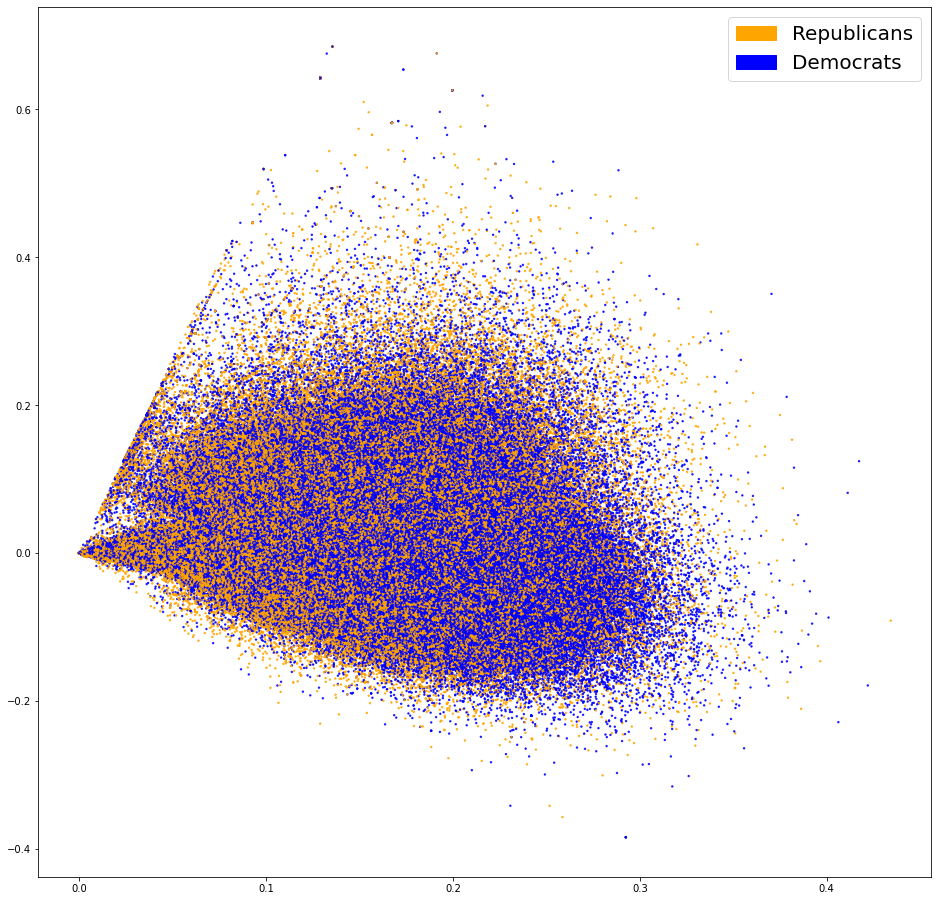

In [49]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidf_train, y_train)
plt.show()

#### Considering the quantity of data we are using, let's say that these embeddings look more or less separated. Now, we check performance:




In [51]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
log_reg.fit(tfidf_train, y_train)

y_hat = log_reg.predict(tfidf_test)

In [53]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_hat): 
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)

    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    

    return accuracy, precision, recall, f1

In [54]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.802, precision = 0.803, recall = 0.802, f1 = 0.802


In [55]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_hat)

array([[66631, 17098],
       [20109, 83927]])

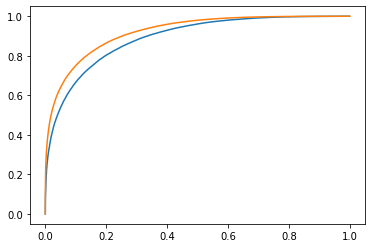

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(tfidf_test)[:, 1])
plt.plot(fpr, tpr)

fpr, tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(tfidf_train)[:, 1])
plt.plot(fpr, tpr)


In [59]:
roc_auc_score(y_test, log_reg.predict_proba(tfidf_test)[:, 1])

0.8891853972628054